#௹Project: ąnt Ćolony Øptimisation ąlgorithm for EPO


In [3]:
from google.colab import files
up_data=files.upload()

Saving data (6).xls to data (6).xls


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax

In [5]:
df=pd.read_excel("data (6).xls")
data=pd.DataFrame(df)
data

,F(mL/mn),t(mn),CO2 selectivity (%),H2/CO ratio,E reformage (kJ/min)
0,x1,x2,y1,y2,y3
1,300,0,2.612023,8.608754,55.598882
2,300,3,17.78595,3.61434,55.598882
3,300,6,7.186041,3.282391,55.598882
4,300,9,8.058988,3.38442,55.598882
...,...,...,...,...,...
144,1000,96,12.949414,3.629843,56.120186
145,1000,99,12.899311,4.881199,56.120186
146,1000,102,13.050234,3.713186,56.120186
147,1000,105,12.965136,3.601106,56.120186


# Pretraitement de la base de donnees:



In [6]:
# === 2. Nettoyage ===
data= data.iloc[1:, :]
data = data.apply(pd.to_numeric, errors="coerce")
data = data.dropna()

In [7]:
data.head()

,F(mL/mn),t(mn),CO2 selectivity (%),H2/CO ratio,E reformage (kJ/min)
1,300,0,2.612023,8.608754,55.598882
2,300,3,17.785950,3.614340,55.598882
3,300,6,7.186041,3.282391,55.598882
4,300,9,8.058988,3.384420,55.598882
5,300,12,7.673889,3.439428,55.598882


Le graphique a été sauvegardé avec succès sous le nom 'analyse_boites_a_moustaches.png'


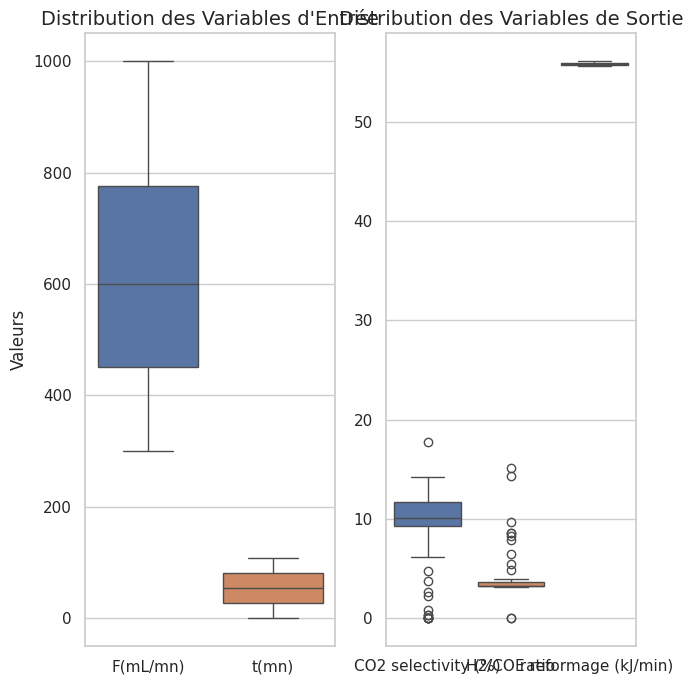

In [8]:
# Étape 1 : Importer les librairies nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Étape 2 : Charger votre fichier de données
# Assurez-vous que votre fichier "data.xls - DATA1.csv" est dans le même dossier que votre script.
try:

    # On saute la deuxième ligne (x1, x2, ...) qui n'est pas une donnée numérique
    df = data

    # Étape 3 : Séparer les variables pour une meilleure clarté
    input_vars = ['F(mL/mn)', 't(mn)']
    output_vars = ['CO2 selectivity (%)', 'H2/CO ratio', 'E reformage (kJ/min)']

    # Étape 4 : Créer les graphiques
    # Configurer le style
    sns.set(style="whitegrid")
    plt.figure(figsize=(7, 7))

    # Graphique pour les variables d'entrée
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df[input_vars])
    plt.title("Distribution des Variables d'Entrée", fontsize=14)
    plt.ylabel("Valeurs")

    # Graphique pour les variables de sortie
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df[output_vars])
    plt.title("Distribution des Variables de Sortie", fontsize=14)

    # Ajuster et sauvegarder le graphique
    plt.tight_layout()
    plt.savefig('analyse_boites_a_moustaches.png')

    print("Le graphique a été sauvegardé avec succès sous le nom 'analyse_boites_a_moustaches.png'")

except FileNotFoundError:
    print(f"Erreur : Le fichier '{file_path}' n'a pas été trouvé. Veuillez vérifier le nom et l'emplacement du fichier.")

In [9]:


print(f"Taille du dataset avant suppression des outliers : {data.shape}")
print("-" * 50)
data_sans_outliers = data.copy()

for column in data_sans_outliers.select_dtypes(include='number').columns:

    # 1. Calcul des bornes (méthode IQR)
    Q1 = data_sans_outliers[column].quantile(0.25)
    Q3 = data_sans_outliers[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 2. Identification des outliers
    outliers = data_sans_outliers[(data_sans_outliers[column] < lower_bound) | (data_sans_outliers[column] > upper_bound)]

    # 3. Affichage du nombre d'outliers trouvés
    if not outliers.empty:
        print(f"Nombre de valeurs aberrantes pour '{column}' : {len(outliers)}")
    data_sans_outliers = data_sans_outliers[(data_sans_outliers[column] >= lower_bound) & (data_sans_outliers[column] <= upper_bound)]

print("-" * 50)
print(f"Taille du dataset après suppression des outliers : {data_sans_outliers.shape}")
print(f"{data.shape[0] - data_sans_outliers.shape[0]} lignes ont été supprimées.")

# On remplace l'ancien dataframe par le nouveau, nettoyé des outliers
data = data_sans_outliers


Taille du dataset avant suppression des outliers : (148, 5)
--------------------------------------------------
Nombre de valeurs aberrantes pour 'CO2 selectivity (%)' : 14
Nombre de valeurs aberrantes pour 'H2/CO ratio' : 1
--------------------------------------------------
Taille du dataset après suppression des outliers : (133, 5)
15 lignes ont été supprimées.


In [10]:

X = data[['F(mL/mn)', 't(mn)']]
targets = ['CO2 selectivity (%)', 'H2/CO ratio', 'E reformage (kJ/min)']

# === 4. Standardisation ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 5. Split train/test ===
X_train, X_test, y_train_full, y_test_full = train_test_split(
    X_scaled, data[targets], test_size=0.3, random_state=42
)

# Best Model pour CO2 selectivity (%):

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

## 16,3*8 is Nice  //RMSE : 0.7861 MAE  : 0.5563 MAPE : 5.45% R²   : 0.7568
## 2*16 2*8 6 is Good 0.79


model_co = Sequential()

# Couche d'entrée
model_co.add(Dense(16, activation='relu', input_shape=(2,)))

model_co.add(Dense(16,activation='relu'))
model_co.add(Dense(16,activation='relu'))


model_co.add(Dense(8,activation='relu'))





# Couche de sortie
model_co.add(Dense(1, activation='linear'))

# Compilation
optimizer = RMSprop(learning_rate=1e-3)
model_co.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])

## model Fiting de H/CO:
# Callback pour arrêter automatiquement à la meilleure époque /// pour avoid the Overfitting, over estimating the train data, les parametre sont subjectif au base d'entrainement
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Entraînement du modèle
history_co = model_co.fit(
    X_train,
    y_train_full['CO2 selectivity (%)'],
    epochs=222,
    batch_size=8,
    validation_split=0.3,
    callbacks=[es],   # ✅ corrigé ici
    verbose=1
)



Epoch 1/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 107.9977 - mae: 10.2954 - val_loss: 110.8014 - val_mae: 10.3351
Epoch 2/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 103.4371 - mae: 10.0699 - val_loss: 106.3812 - val_mae: 10.1145
Epoch 3/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 99.0682 - mae: 9.8473 - val_loss: 101.4962 - val_mae: 9.8637
Epoch 4/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 94.1004 - mae: 9.5870 - val_loss: 95.7303 - val_mae: 9.5569
Epoch 5/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 88.2786 - mae: 9.2710 - val_loss: 89.0804 - val_mae: 9.1880
Epoch 6/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 81.6364 - mae: 8.8949 - val_loss: 81.4586 - val_mae: 8.7438
Epoch 7/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 74.1045 - mae: 8.4461 - val_loss: 72.8959 - val_mae: 8.2122
Epoch 8/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 65.7625 - mae: 7.9165 - val_loss: 63.7373 - val_mae: 7.5953
Epoch 9/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/st

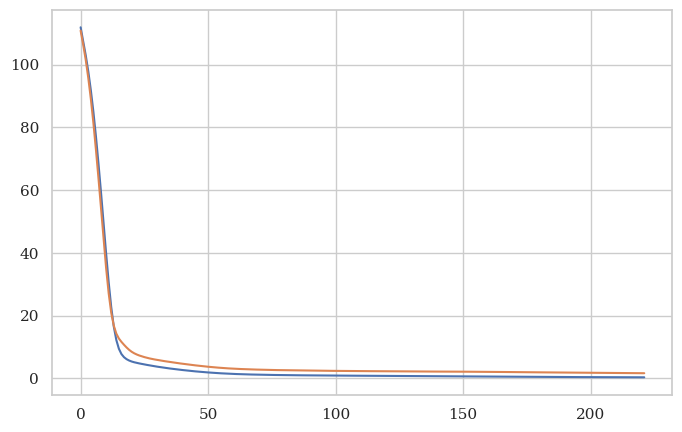

In [61]:
plt.plot(history_co.history['loss'],label="Loss")
plt.plot(history_co.history['val_loss'],label="validation_loss")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
📊 Évaluation du modèle :
RMSE : 0.8774
MAE  : 0.6672
MAPE : 6.68%
R²   : 0.6970


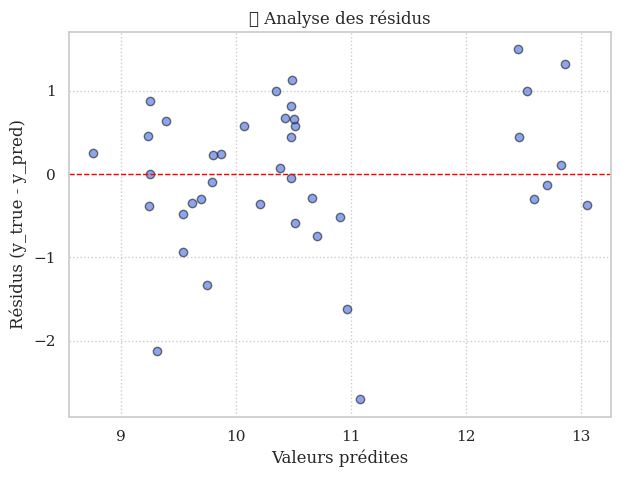

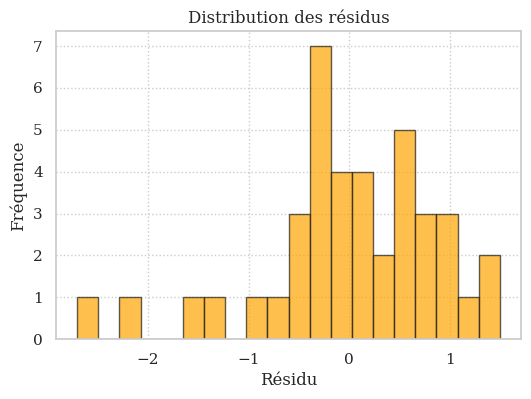

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# 🔹 1. Prédictions sur les données de test
y_pred = model_co.predict(X_test).flatten()
y_true = y_test_full['CO2 selectivity (%)'].values  # à adapter selon ton jeu de test

# 🔹 2. Calcul des métriques
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # en %
r2   = r2_score(y_true, y_pred)

# 🔹 3. Affichage des résultats
print("📊 Évaluation du modèle :")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")

# 🔹 4. Courbe des résidus
residuals = y_true - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, color='royalblue', alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus (y_true - y_pred)")
plt.title("📉 Analyse des résidus")
plt.grid(True, linestyle=':')
plt.show()

# 🔹 5. (Optionnel) Histogramme des résidus
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, color='orange', edgecolor='k', alpha=0.7)
plt.title("Distribution des résidus")
plt.xlabel("Résidu")
plt.ylabel("Fréquence")
plt.grid(True, linestyle=':')
plt.show()


# Model de H2/CO ratio :

Epoch 1/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 31.4207 - mae: 5.4367 - val_loss: 11.6598 - val_mae: 3.1916
Epoch 2/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.5038 - mae: 2.6771 - val_loss: 4.5876 - val_mae: 1.7810
Epoch 3/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.4901 - mae: 1.5530 - val_loss: 2.2215 - val_mae: 1.2292
Epoch 4/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7604 - mae: 1.1120 - val_loss: 1.4272 - val_mae: 1.0377
Epoch 5/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1452 - mae: 0.9330 - val_loss: 1.1035 - val_mae: 0.9432
Epoch 6/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8372 - mae: 0.7984 - val_loss: 0.8788 - val_mae: 0.8492
Epoch 7/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6115 - mae: 0.6827 - val_loss: 0.6777 - val_mae: 0.7342
Epoch 8/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4331 - mae: 0.5718 - val_loss: 0.5010 - val_mae: 0.6162
Epoch 9/222
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3005 - mae

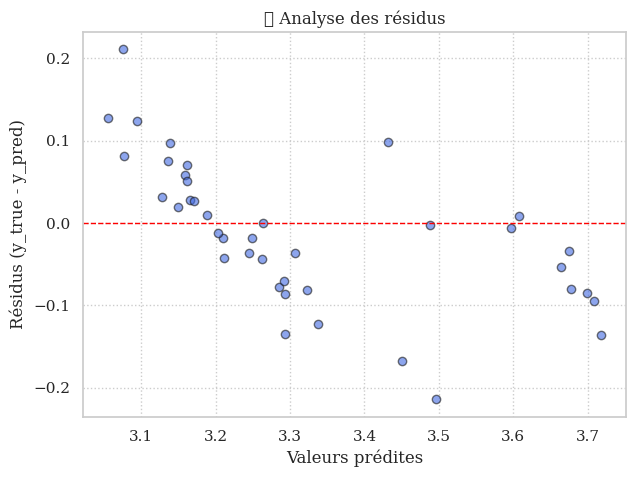

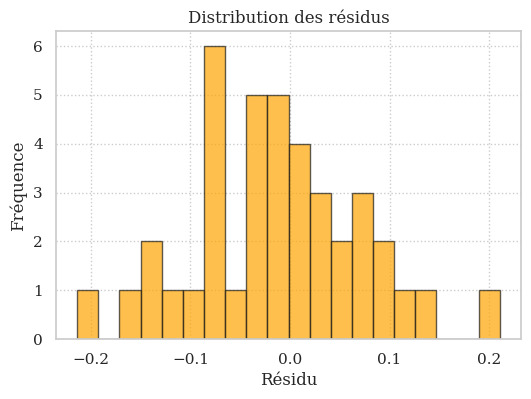

In [41]:
# Model de H2/CO:
# Callback pour arrêter automatiquement à la meilleure époque /// pour avoid the Overfitting, over estimating the train data, les parametre sont subjectif au base d'entrainement
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Entraînement du modèle
history_co = model_co.fit(
    X_train,
    y_train_full['H2/CO ratio'],
    epochs=222,
    batch_size=8,
    validation_split=0.3,
    callbacks=[es],   # ✅ corrigé ici
    verbose=1
)
## Ploting:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# 🔹 1. Prédictions sur les données de test
y_pred = model_co.predict(X_test).flatten()
y_true = y_test_full['H2/CO ratio'].values  # à adapter selon ton jeu de test

# 🔹 2. Calcul des métriques
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # en %
r2   = r2_score(y_true, y_pred)

# 🔹 3. Affichage des résultats
print("📊 Évaluation du modèle :")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")

# 🔹 4. Courbe des résidus
residuals = y_true - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, color='royalblue', alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus (y_true - y_pred)")
plt.title("📉 Analyse des résidus")
plt.grid(True, linestyle=':')
plt.show()

# 🔹 5. (Optionnel) Histogramme des résidus
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, color='orange', edgecolor='k', alpha=0.7)
plt.title("Distribution des résidus")
plt.xlabel("Résidu")
plt.ylabel("Fréquence")
plt.grid(True, linestyle=':')
plt.show()



In [42]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV
rmse_scores = []
mae_scores = []
r2_scores = []

X_np = X_train # si DataFrame pandas
y_np = y_train_full['CO2 selectivity (%)'].values
## untilisation de K_fold kross valisation , diviser la base train en k fold puis permuter ces fold pour K-1 de train, 1 de test et puis choisir le meilleur model et le valider par la base de validation
kf=KFold(n_splits=5)
## this means that the KFold method take as a parameter K, the number of Folds
## th

for i,j in kf.split(X_np):



SyntaxError: incomplete input (ipython-input-3460530288.py, line 16)

In [21]:


# Création des trois modèles (Y1, Y2, Y3)
model_Y1 = model_co
model_Y2 = model_HCO
model_Y3 =

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.8/303.8 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.7 MB/s eta 0:00:00
✅ Modèle 'Y1_CO2_selectivity' créé avec l'architecture multi-couches spécifiée.
✅ Modèle 'Y2_H2_CO_ratio' créé avec l'architecture multi-couches spécifiée.
✅ Modèle 'Y3_E_reformage' créé avec l'architecture multi-couches spécifiée.


In [ ]:
# Optimisation multi-objectif (NSGA-II & ACOR)

# Optimisation multi-objectif (NSGA-II & ACOR)

In [20]:
# Imports de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, math
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D

# Deep learning
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.optimizers import Adam
    KERAS_AVAILABLE = True
except Exception as e:
    print("Keras/TensorFlow non disponible :", e)
    KERAS_AVAILABLE = False

# Seed pour reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
if KERAS_AVAILABLE:
    tf.random.set_seed(SEED)

# Affichage
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)
